## Lesson 1: Introduction and motivation

See [slides](https://docs.google.com/presentation/d/1O5v1qFMQEe430aynnaq-4gR0cMvqSsYfsaHJ4RoHpoE/edit#slide=id.g2ee3908cf2f_0_0)

## Lesson 2: LangGraph Studio

We've [released an IDE called LangGraph Studio](https://blog.langchain.dev/langgraph-studio-the-first-agent-ide/), which supports agentic workflows! 

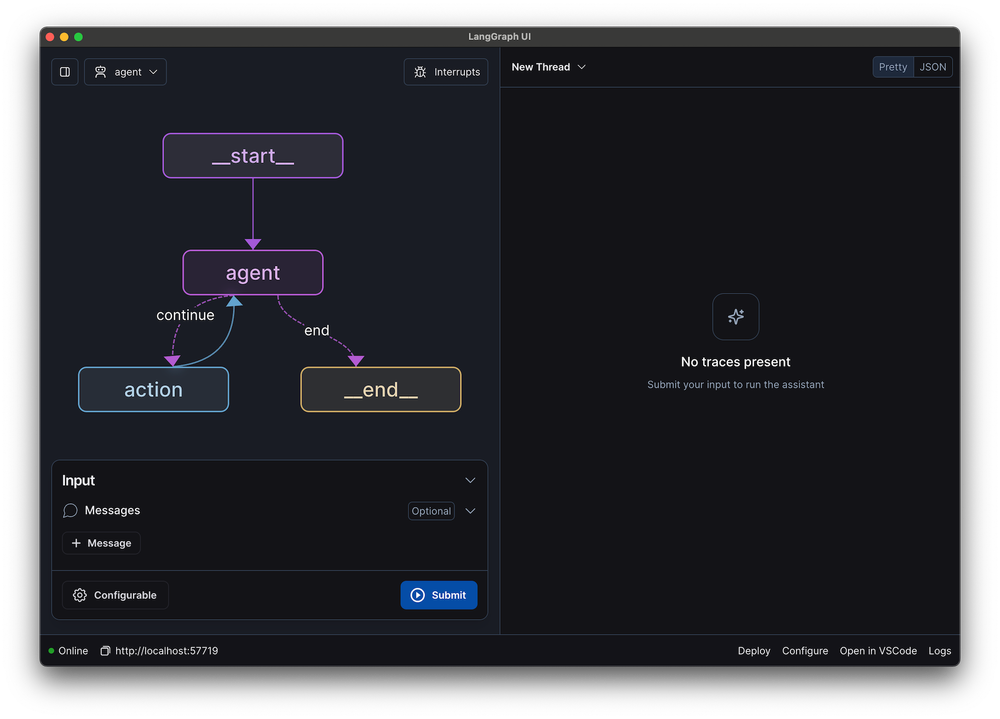

We'll be incorperating LangGraph studio into the lessons.

You can download it [here](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#download) and setup a LangSmith account.

## Lesson 3: The Simplest Graph

Let's build a simple 3 step graph:

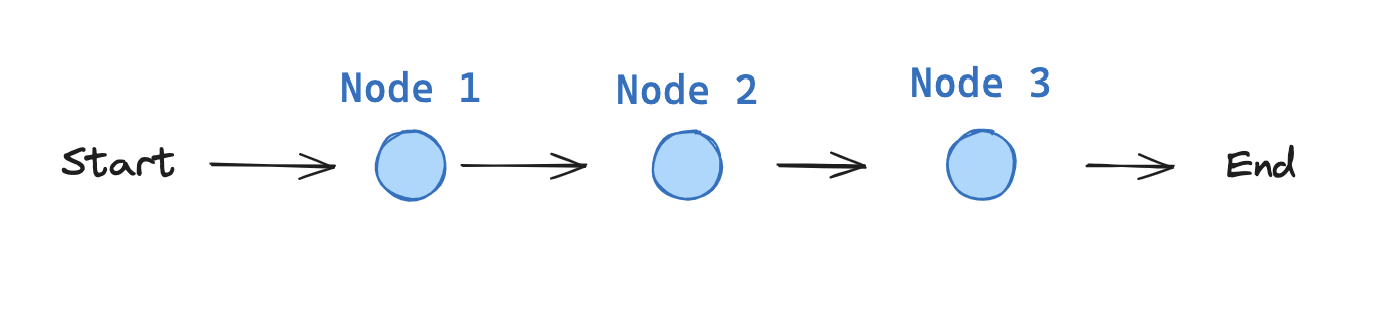

### Graph Definition

`State Definition:`
* Initialize graph (`StateGraph`) by passing a state schema 
* Here, state schema is a `TypedDict` with a single `input` field
* This represents the shared data structure for the graph
 
`Node Functions:`
* Three functions defined: `node_1`, `node_2`, `node_3`
* Each function represents a node in the graph
* Functions take state as input and print a step message

`Graph Construction:`
* Initializes StateGraph with the State class
* Adds nodes using `add_node()` method
* Creates edges using `add_edge()` method
* Linear structure: `START -> node_1 -> node_2 -> node_3 -> END`
* Uses special `START` and `END` nodes for entry and exit points

`Graph Compilation:`
* Compiles the graph using `builder.compile()`
* Performs basic checks on graph structure
* Prepares the graph for execution

`Visualization:`
* Uses built-in visualization capabilities
* Generates and displays a Mermaid diagram of the graph structure

Reference: https://langchain-ai.github.io/langgraph/concepts/low_level/

In [22]:
%%capture --no-stderr
%pip install --quiet -U langgraph

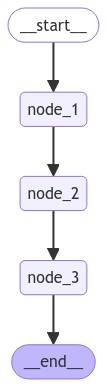

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# State
class State(TypedDict):
    input: str

# Nodes
def node_1(state):
    print("---Node 1---")
    return {"input":state['input'] +" my"}


def node_2(state):
    print("---Node 2---")
    return {"input":state['input'] +" first"}


def node_3(state):
    print("---Node 3---")
    return {"input":state['input'] +" graph"}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

`Input`
 
* The input is a dictionary `{"input":"hello world"`}
* This matches the State structure defined earlier
* This input becomes the initial state of the graph execution

`Execution Process:`
 
* When `invoke` is called, the graph starts execution from the `START` node.
* It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.
* Each node function receives the current state and can modify it.
* The execution continues until it reaches the `END` node.

`State Management:`
 
* The initial input state is passed through each node.
* Nodes can read from and write to this state.
* In this simple example, the nodes only print messages, but in a more complex graph, they could modify the state.

`Synchronous Operation:`
 
* `invoke` runs the entire graph synchronously
* This waits for each step to complete before moving to the next

`Return Value:`
 
* The invoke method returns the final state of the graph after all nodes have executed.
* In this case, it would return the state after `node_3` has completed.

In [2]:
graph.invoke({"input":"This is"})

---Step 1---
---Step 2---
---Step 3---


{'input': 'This is my first graph'}

## Lesson 4: LLM Chain

Now, let's build up to a simple chain that combines 4 key [concepts](https://python.langchain.com/v0.2/docs/concepts/):

1) Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph
2) Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
3) [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our LLM
4) [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in our graph 

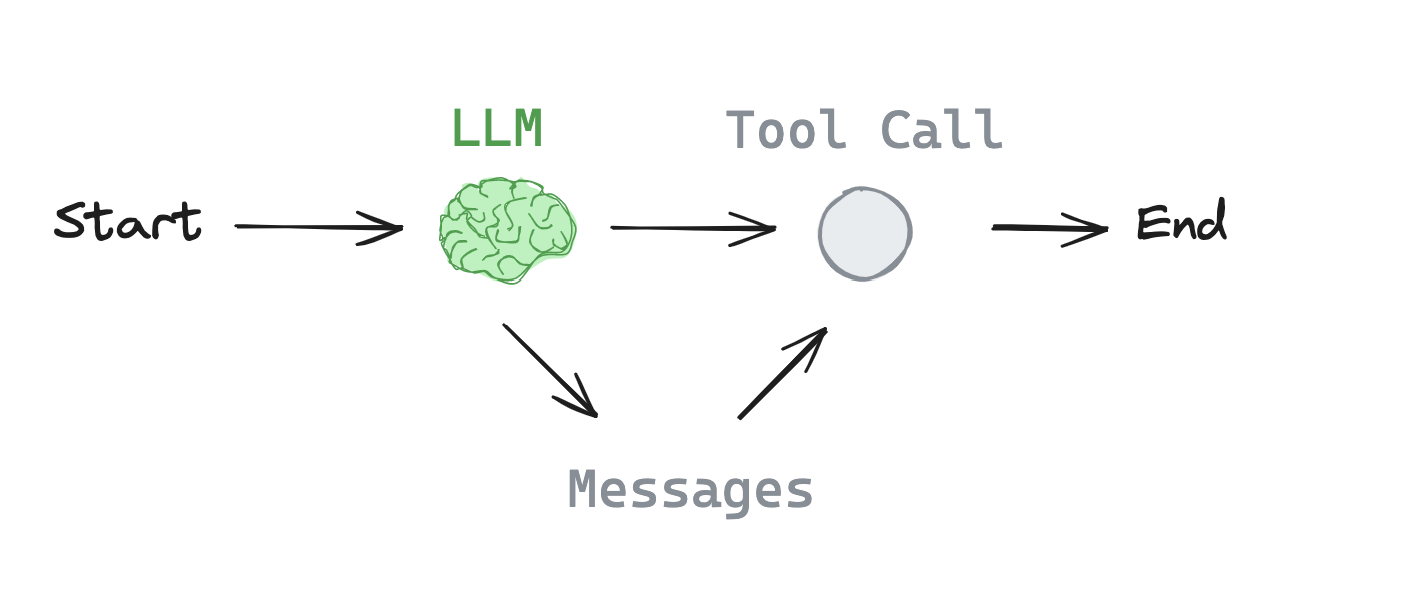

Here, ensure your `OPENAI_API_KEY` is set:

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

### Binding tools

Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/).

The [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 

You can pass any Python function into `ChatModel.bind_tools()`.

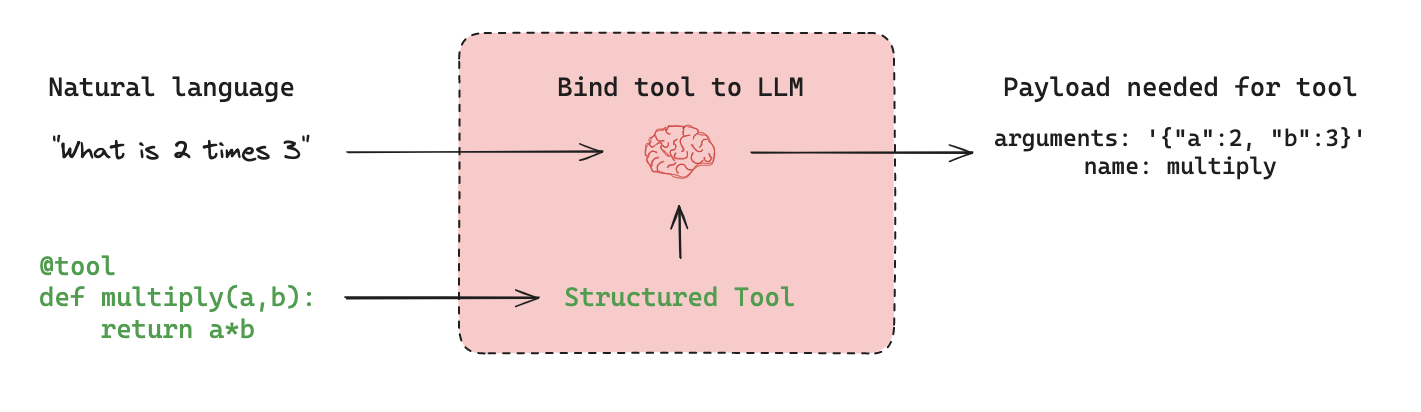

In [4]:
from langchain_openai import ChatOpenAI

# This will be a tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# LLM with bound tool
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

### Messages

We'll use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

There are a few ideas related to the use of `messages`:

`Reducer Function:`

* A [reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) is a function that determines how updates are applied to a specific key in the state.
* In this case, `add_messages` is the reducer function used for the `messages` key.

`MessageState:`

* `MessagesState` is a [specialized state](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagestate) type designed for handling message-based conversations.
* It's defined as a `TypedDict` with a single key: `messages`.
* The `Annotated` type is used to associate the `add_messages` reducer with the `messages` key.

`add_messages Reducer:`
* This reducer is specifically designed for handling message lists.
* Instead of overwriting the existing messages, it appends new messages to the current list.
* It handles various message formats and ensures proper integration of new messages.

`How the Reducer Works:`
* When a node returns an update like `{"messages": [new_message]}`:
* The `add_messages` reducer is called.
* It takes the existing `messages` list and the new message(s).
* It appends the new message(s) to the existing list.
* This allows for maintaining a conversation history without manually managing the list.
 
`Benefits of Using MessageState:`
* Simplifies state management for conversational applications.
* Automatically handles message appending without explicit list operations.
* Ensures consistent handling of different message types (HumanMessage, AIMessage, ToolMessage, etc.).


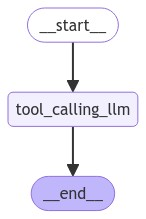

In [5]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# State
class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages]

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Here, the LLM responds normally without any tool calls.

In [7]:
messages = graph.invoke({"messages": ("user", "Hello!")})
messages['messages'][-1]

AIMessage(content='Hi there! How can I help you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 54, 'total_tokens': 65}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-0bef67f6-9137-4f65-896a-f2022372f9ed-0', usage_metadata={'input_tokens': 54, 'output_tokens': 11, 'total_tokens': 65})

Now, we can see that a tool call is performed if our input related to the tool!

In [6]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
messages['messages'][-1].tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 2},
  'id': 'call_XCxS5HjnirZqAMZFgrynUkiv',
  'type': 'tool_call'}]

### Calling tools

Now, we can add a node to call the tool specifically.

We can use the built-in `ToolNode` and simply pass a list of our tools.

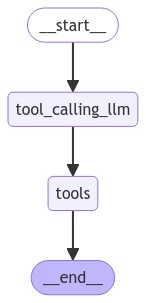

In [7]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode

# Build grapp
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", "tools")
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

In [8]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
messages['messages'][-1]

ToolMessage(content='6', name='multiply', id='a1747017-2083-42ea-a3ed-e66539ddb1b2', tool_call_id='call_fiQpCK6A87dbygZTZo4EEtAA')

Here, we can also introduce [LangGraph Studio](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file).

This is free to anyone with a LangSmith account.

It offers an agent IDE that enables visualization, interaction, and debugging of complex agentic applications. 

Follow the `README` [here](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file) to set up LangGraph Studio.

Load the above graph with `chain.py`. 

We can interact with our loaded graph, as shown above. 

We'll explore more advanced usage of studio in future lessons and modules!

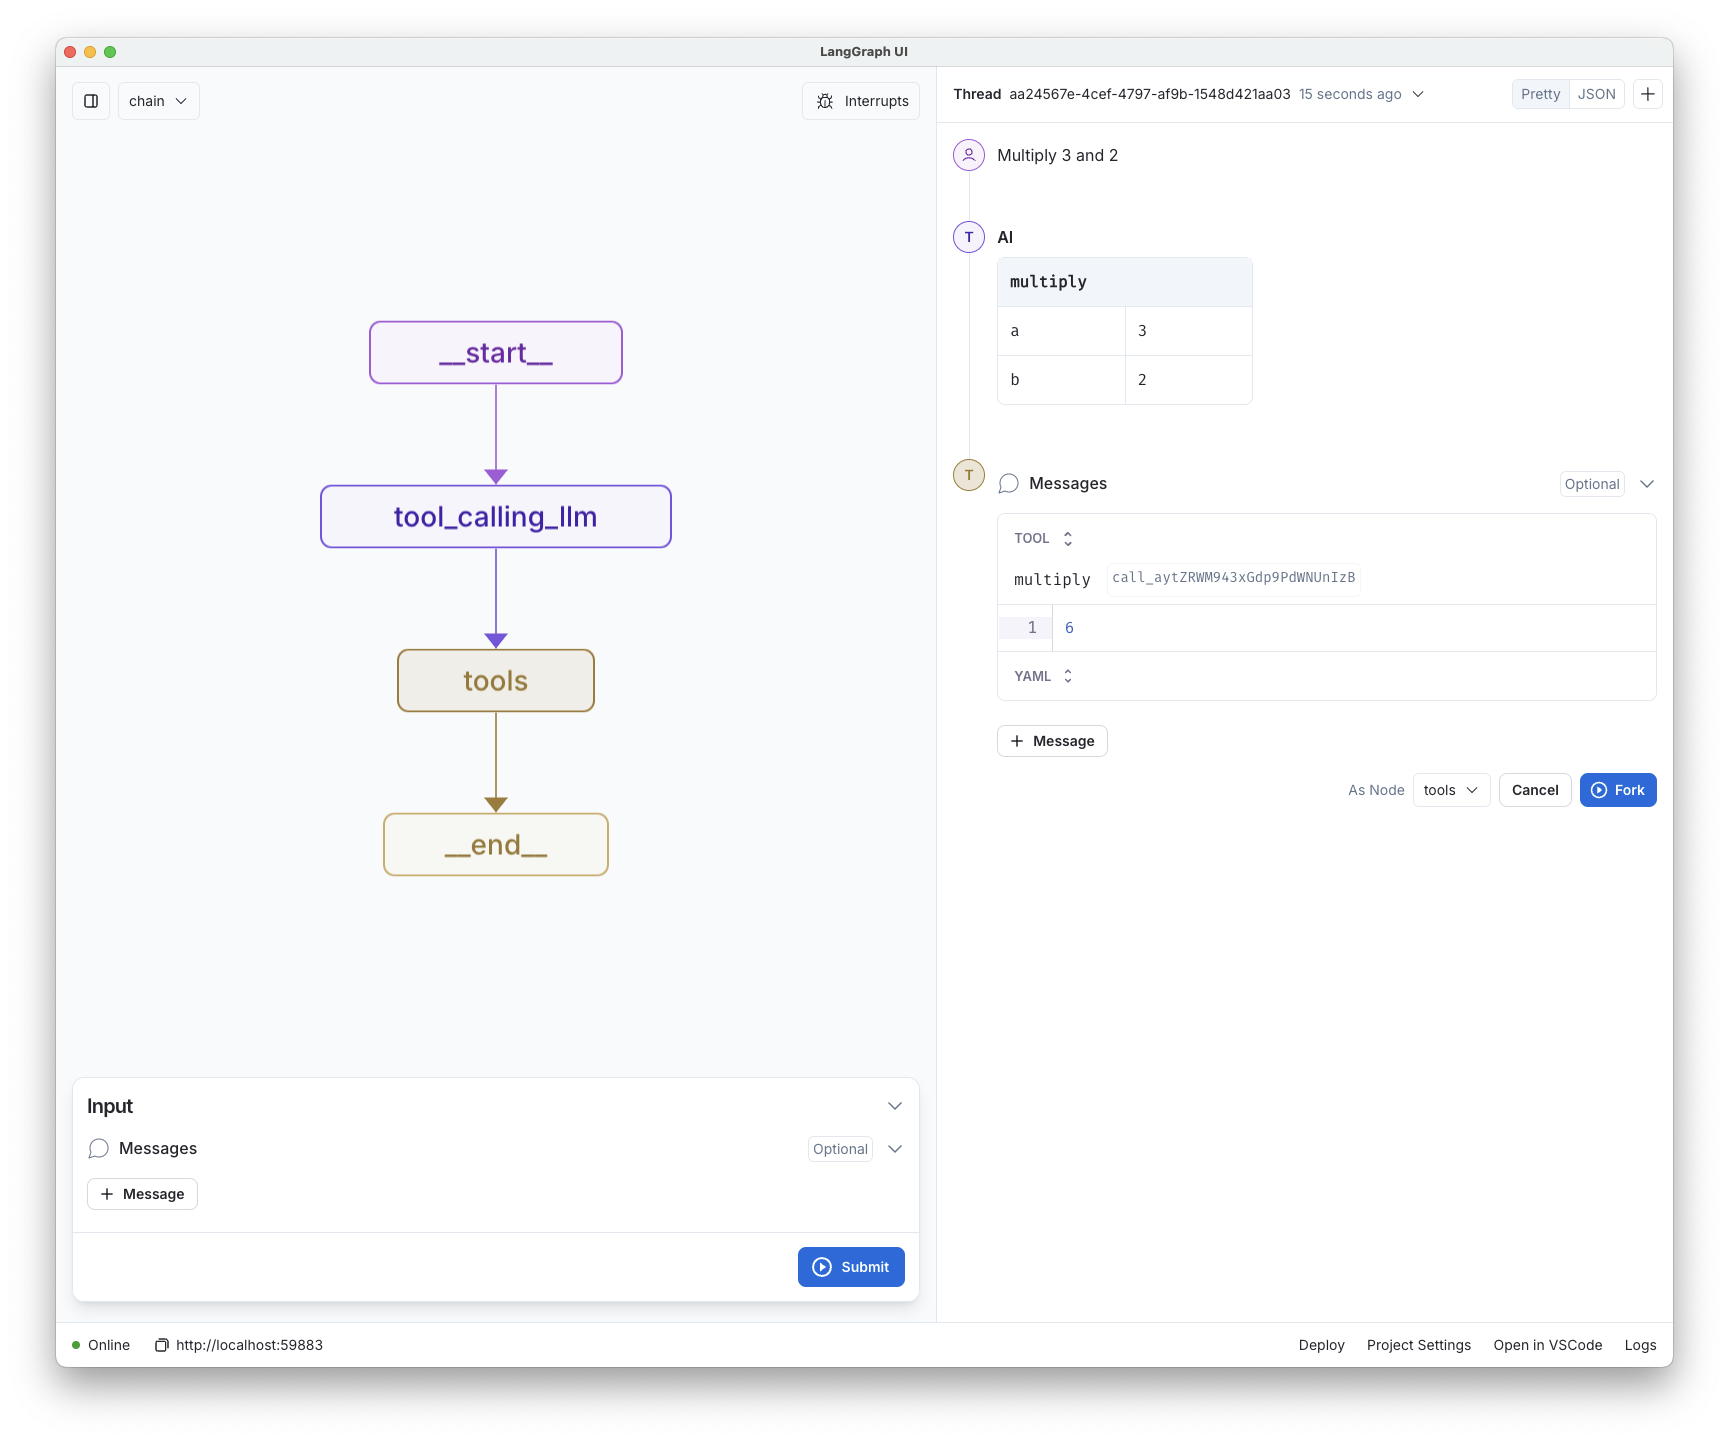

## Lesson 5: ReAct

With the above concepts clear, we can combine these into a [tool calling agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/)! 

The idea is simple: 

Above, we invoked our LLM, it chose to call a tool, and the tool executed, resuting a `ToolMessage`.

Above, we just returned the raw `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` back to the LLM and let it either:

* Call another tool
* Or, just respond directly based upon the tool's output

This is the basic intution behind [ReAct](https://react-lm.github.io/), a simple, general, and flexible framework for building agents.
  
(1) `act` - call specific tools 
 
(2) `observe` - pass the tool outputs back to the LLM
 
(3) `reason` - about the tool output to decide what to do next 

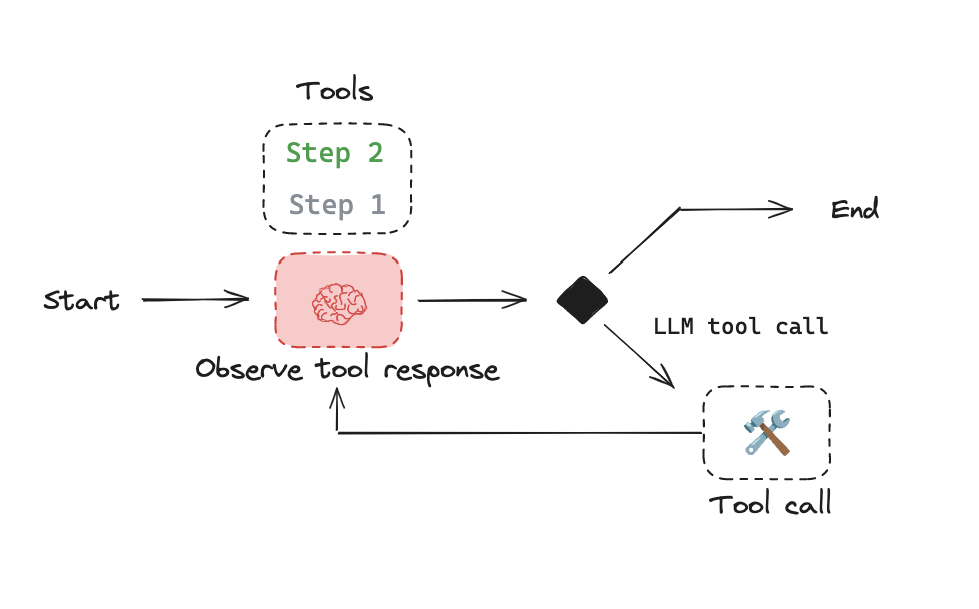

This [general purpose cognitive architecture](https://blog.langchain.dev/planning-for-agents/) can applied to any set of tools. 
 
Let's create a few new tools, `add` and `divide`.

In [9]:
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

Let's create our LLM and prompt it with the overall desired agent behavior.

In [10]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant
class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.
        """
        self.runnable = runnable

    def __call__(self, state: MessagesState, config: RunnableConfig):
        """
        Call method to invoke
        """
        result = self.runnable.invoke(state)  
        return {"messages": result}

# Assistant prompt
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            " You are a helpful assistant tasked with writing performing arithmatic on a set of inputs. "
         ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

`State Management:`

* Uses `MessagesState`, a TypedDict with a single key 'messages'.
* The 'messages' key is annotated with `add_messages`, a reducer function that appends new messages to the existing list.

`Tools:`
* Defines a list of tools.
* These tools are bound to the LLM.

`Assistant:`
* Implements an `Assistant` class that wraps a runnable object (the LLM with bound tools).
* The assistant processes the current state and returns updated messages.

`Graph Structure:`
* Creates a `StateGraph` with two main nodes: "assistant" and "tools".
* The "assistant" node runs the LLM with the current state.
* The "tools" node executes the appropriate tool based on the LLM's output.

`Conditional Edge:`
* Uses `add_conditional_edges` with the `tools_condition` function.
* This is crucial for the ReAct architecture:
* After the "assistant" node executes, `tools_condition` checks if the LLM's output is a tool call.
* If it is a tool call, the flow is directed to the "tools" node.
* If it's not a tool call, the flow is directed to END, terminating the process.

Overall, the loop will continue so long as the LLM decides to call specific tools.

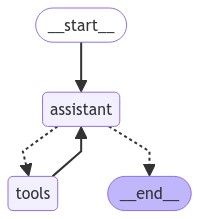

In [12]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

`Flow:`
* Starts at the "assistant" node.
* The assistant generates a response or a tool call.
* If it's a tool call, the flow goes to the "tools" node, which executes the tool.
* After tool execution, it loops back to the "assistant" node.
* This cycle continues until the assistant doesn't make a tool call, at which point it ends.
 
The conditional edge is key to implementing the ReAct architecture. It allows the agent to:
1. Reason about whether to use a tool (in the "assistant" node).
2. Act by calling the tool if needed (routing to the "tools" node).
3. Observe the results (by looping back to the "assistant" node with updated state).
4. Decide when to stop (by not making a tool call, which routes to END).

In [13]:
messages = react_graph.invoke({"messages": ("user", "Add 3 and 4, then multiple by 2, and finally divide by 5")})
messages['messages'][-1]

AIMessage(content='The result of adding 3 and 4, then multiplying by 2, and finally dividing by 5 is 2.8.', response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 227, 'total_tokens': 256}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-0e542352-dfda-4050-825e-820f0cf9623a-0', usage_metadata={'input_tokens': 227, 'output_tokens': 29, 'total_tokens': 256})

As shown above, we can develop and interact with our agent in Studio.

Simply load `agent.py`. 

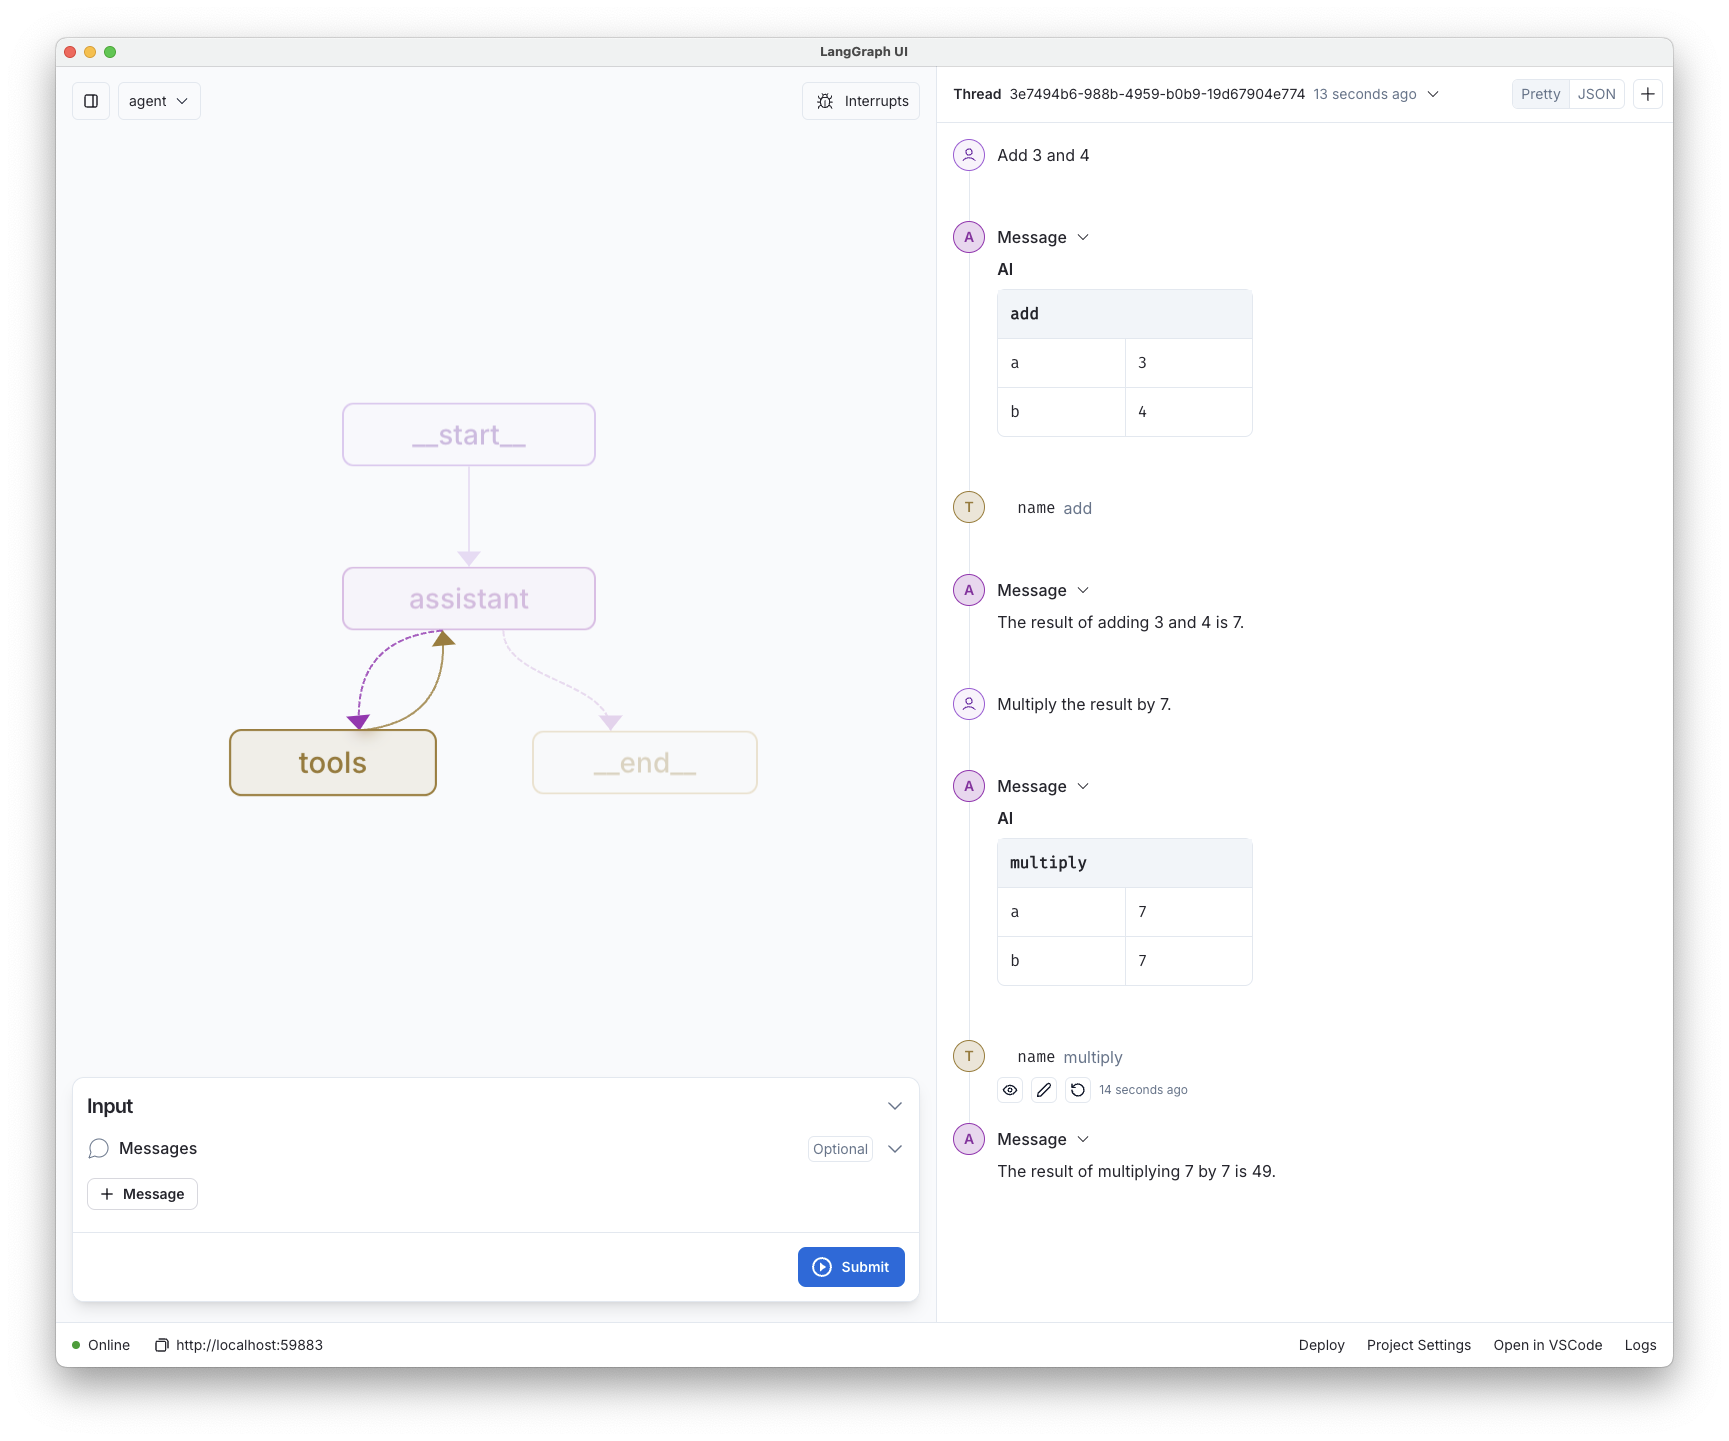

### Lesson 6: ReAct with Memory

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. 

This limits its ability to have coherent, multi-turn conversations.

We can use [memory](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph has support for various types of memory.

One of the easiest to work with is simply `MemorySaver`, an in-memory key-value store for your graph state.

This allows the graph to save its state after each step.

In [14]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compile with memory
react_graph_memory = builder.compile(checkpointer=memory)

`configurable` sets up a configuration with a thread ID.

This thread ID will maintain a specific conversation state.

When we stream, by default we will return a `key`-`value` pair of `node`-`state`.

We can simply only stream the state by passing `stream_mode="values"`.

In [15]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! Add 3 and 4"
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_hqsxtZ9nOXxnHaBWcmaaLQMH)
 Call ID: call_hqsxtZ9nOXxnHaBWcmaaLQMH
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [16]:
event

{'messages': [HumanMessage(content='Hi there! Add 3 and 4', id='9d05245c-804a-4f68-8c41-ac584e5ea4be'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hqsxtZ9nOXxnHaBWcmaaLQMH', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 140, 'total_tokens': 157}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-89b588e8-07b5-448d-9eb9-1ebcbe98ad38-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_hqsxtZ9nOXxnHaBWcmaaLQMH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 140, 'output_tokens': 17, 'total_tokens': 157}),
  ToolMessage(content='7', name='add', id='86182fb9-65b6-4a73-9a89-43e4c4f4ae81', tool_call_id='call_hqsxtZ9nOXxnHaBWcmaaLQMH'),
  AIMessage(content='The sum of 3 and 4 is 7.', response_metadata={'token_usage': {'completion_tokens': 13, 'prom

The `Configuration Setup` with thread ID allows us to proceed from the previously logged state.

In [17]:
user_input = "Take that output, and multiply it by 3!"

# The config is the **second positional argument** to stream() or invoke()!
events = react_graph_memory.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Take that output, and multiply it by 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_IOOpbLvYzfyE7RWctwvbK00f)
 Call ID: call_IOOpbLvYzfyE7RWctwvbK00f
  Args:
    a: 7
    b: 3
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message ==================================

The result of multiplying 7 by 3 is 21.


In [18]:
snapshot = react_graph_memory.get_state(config)

`Overall:`

- The use of a checkpointer allows the graph to maintain state between interactions.
- The thread ID in the config ensures that multiple conversations can be managed separately.
- By using the same thread ID in both interactions, the graph maintains context, allowing for coherent multi-turn conversations.
- The `stream()` method is used instead of `invoke()`, allowing for real-time processing and display of responses.
- The state snapshots (`get_state()`) provide a way to inspect the internal state of the conversation at different points.

When you work with the agent in Studio, [it will automatically create a new thread](https://github.com/langchain-ai/langgraph-studio?tab=readme-ov-file#create-a-thread).